## Load libraries

In [2]:
from dotenv import dotenv_values
import numpy as np
import warnings
import os
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)

from HurstIndexSolver.HurstIndexSolver import HurstIndexSolver
from HurstIndexSolver.fgn import fgn
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")

### Load data and initialize variables

In [4]:
start_date = "2005-01-01"
end_date = "2023-12-31"
df_path = "../data/raw/spy.csv"

In [3]:
config = dotenv_values("../config/.env")

In [4]:
ALPHA_API = config["ALPHA_API"]

In [3]:
def get_df(path: str) -> pd.DataFrame:
    if os.path.isfile(path):
        df = pd.read_csv(path, parse_dates=True, index_col=0)
    else:
        df = yf.download("SPY", start=start_date, end=end_date)
        df.to_csv(path)
    return df

In [5]:
spy = get_df(df_path)

[*********************100%%**********************]  1 of 1 completed


In [7]:
spy = spy[spy.index < "31-12-2017"]

### Compute Hurst according to Zhang

In [8]:
HSolver = HurstIndexSolver()

In [9]:
max_scale = 100
HSolver.EstHurstLSSD(np.diff(spy["Close"].values), max_scale=max_scale)

0.467446570335479

### Multifractal simulation

In [10]:
from MMAR.MMAR import MMAR

In [11]:
mmar = MMAR(spy["Close"], volume=spy["Volume"])

In [12]:
mmar.get_alpha_min()

0.1474322398793105

In [13]:
mmar.get_scaling()

(array([-1.        , -1.03255376, -1.02747292, ...,  1.43973262,
         1.44127135,  1.44280988]),
 array([ 1.00000000e+00, -2.13268110e-02, -7.58431230e-02, ...,
        -2.93271570e+01, -2.93494932e+01, -2.93718278e+01]),
 array([0.00000000e+00, 1.00000000e-02, 2.00100100e-02, ...,
        9.98997998e+00, 9.99998999e+00, 1.00100000e+01]))

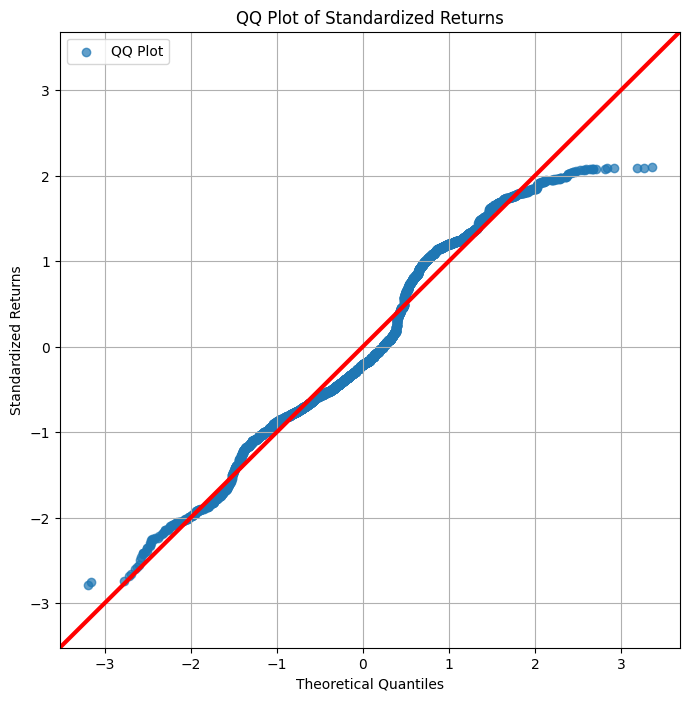

In [14]:
mmar.plot_qq()

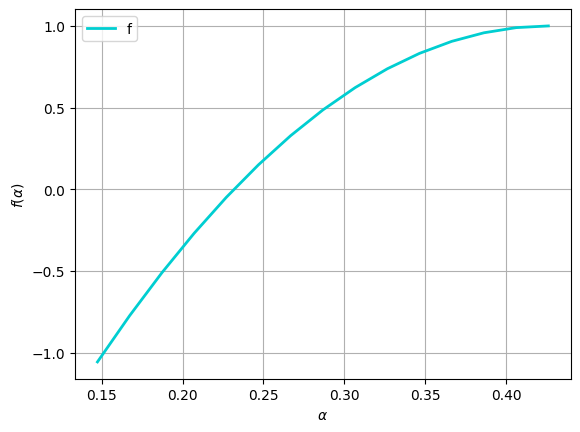

In [17]:
mmar.plot_alpha()

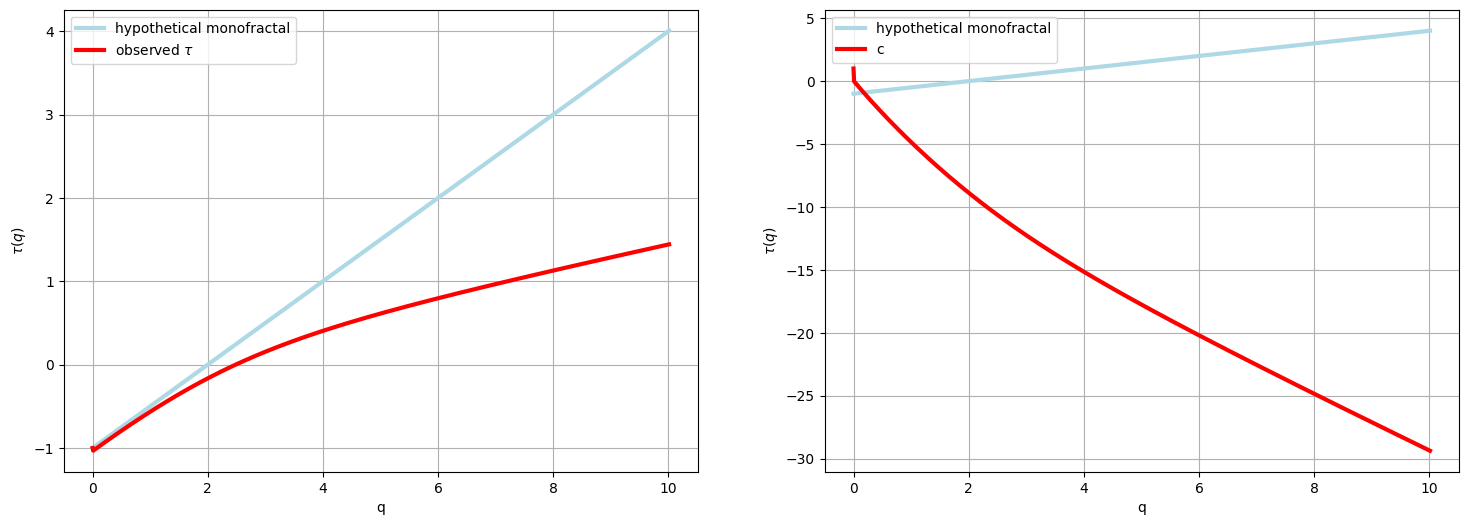

In [18]:
mmar.plot_scaling()

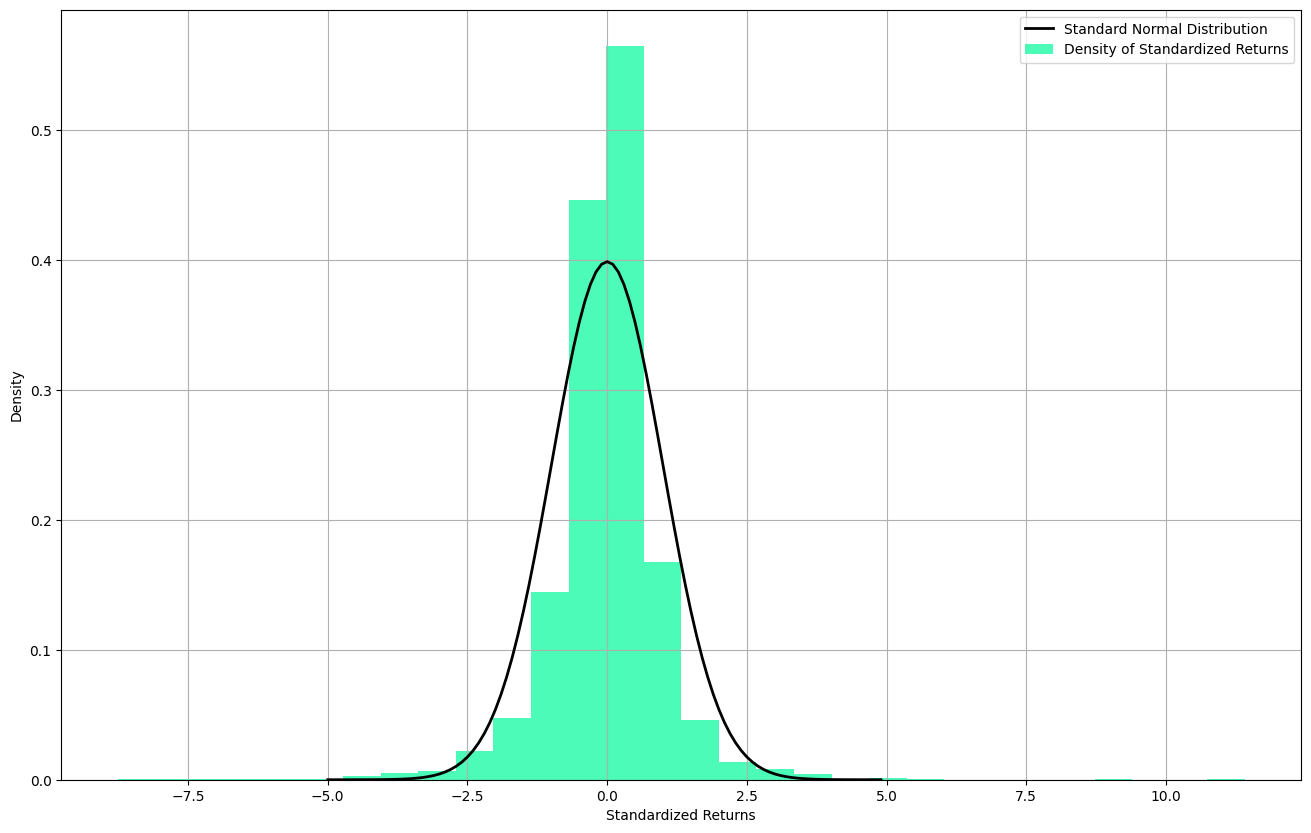

In [19]:
mmar.plot_density()

In [41]:
print(f"According to the MMAR model, the Hurst exponent is {mmar.H:.2f} (rounded)")

According to the MMAR model, the Hurst exponent is 0.40 (rounded)


In [24]:
S0 = spy.Close.iloc[-1]
simulation = mmar.get_MMAR_MC(S0, n=22, num_sim=5_000_000, seed=2048)

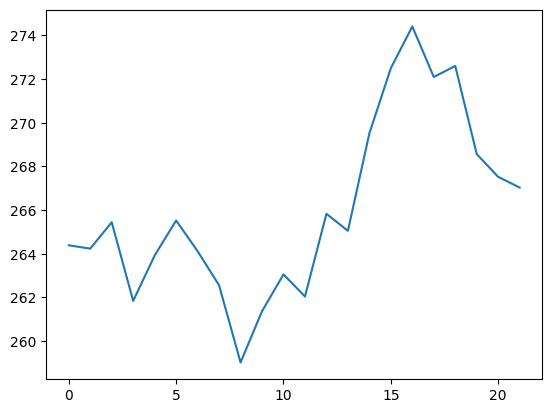

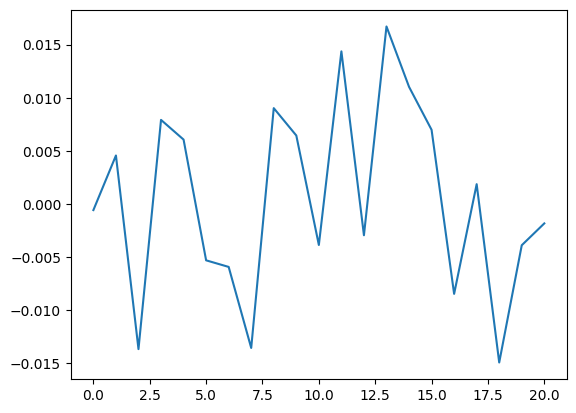

In [25]:
mmar_sim_sample = simulation[0, :]

plt.plot(mmar_sim_sample)
plt.show()

sim_log_diff = np.diff(np.log(mmar_sim_sample))
plt.plot(sim_log_diff)
plt.show()

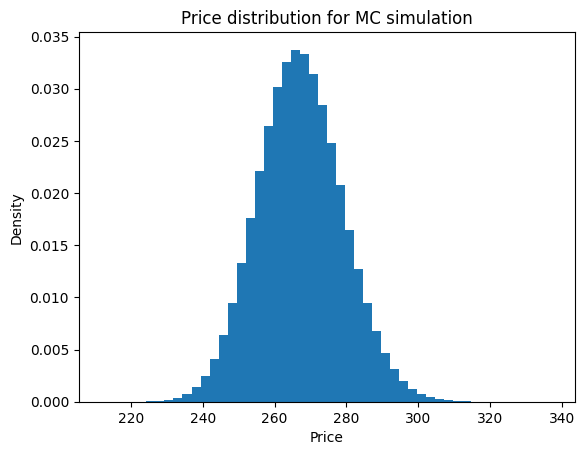

In [26]:
plt.hist(simulation[:, -1:], bins=50, density=True)
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Price distribution for MC simulation")
plt.show()

In [27]:
def get_call_price(prices, strike, r, T):
    values = prices[prices > strike]
    prob = len(values) / len(prices)
    exp_val = np.mean(values)
    print(f"Probability expected price {exp_val:.2f} > {strike:.2f} is {prob:.2%}")
    return np.exp(-r * T) * prob * (exp_val - strike)

In [28]:
# test stability
# We call the simulation with different seed values.
S0 = spy.Close.iloc[-1]
for i in range(10):
    simulation = mmar.get_MMAR_MC(S0, n=22, num_sim=1_000_000, seed=i)
    print(round(get_call_price(simulation[:, -1:], 269, 3 / 100, 22 / 360), 2))

Probability expected price 277.99 > 269.00 is 42.84%
3.84
Probability expected price 277.99 > 269.00 is 42.89%
3.85
Probability expected price 277.99 > 269.00 is 42.82%
3.84
Probability expected price 278.00 > 269.00 is 42.87%
3.85
Probability expected price 277.98 > 269.00 is 42.80%
3.84
Probability expected price 277.99 > 269.00 is 42.88%
3.85
Probability expected price 278.01 > 269.00 is 42.85%
3.85
Probability expected price 278.00 > 269.00 is 42.82%
3.85
Probability expected price 277.99 > 269.00 is 42.75%
3.84
Probability expected price 277.98 > 269.00 is 42.78%
3.83


In [29]:
# We repeat the test above with a new generated object (using the same default seed)
mmar2 = MMAR(spy["Close"], volume=spy["Volume"])
# test stability
S0 = spy.Close.iloc[-1]
for i in range(10):
    simulation = mmar2.get_MMAR_MC(S0, n=22, num_sim=1_000_000, seed=i)
    print(round(get_call_price(simulation[:, -1:], 269, 3 / 100, 22 / 360), 2))

Probability expected price 277.99 > 269.00 is 42.84%
3.84
Probability expected price 277.99 > 269.00 is 42.89%
3.85
Probability expected price 277.99 > 269.00 is 42.82%
3.84
Probability expected price 278.00 > 269.00 is 42.87%
3.85
Probability expected price 277.98 > 269.00 is 42.80%
3.84
Probability expected price 277.99 > 269.00 is 42.88%
3.85
Probability expected price 278.01 > 269.00 is 42.85%
3.85
Probability expected price 278.00 > 269.00 is 42.82%
3.85
Probability expected price 277.99 > 269.00 is 42.75%
3.84
Probability expected price 277.98 > 269.00 is 42.78%
3.83


If we use a different seed for the MMAR object init, we get different values: FIXED! We used the volume to geta a proxy for theta.

In [30]:
# The default seed is 42; let's try a different value. We should get a completely different output if we do not pass the Volume series, the same on the other hand.
mmar3 = MMAR(spy["Close"], seed=21, volume=spy["Volume"])
# test stability
S0 = spy.Close.iloc[-1]
for i in range(10):
    simulation = mmar3.get_MMAR_MC(S0, n=22, num_sim=1_000_000, seed=i)
    print(round(get_call_price(simulation[:, -1:], 269, 3 / 100, 22 / 360), 2))

Probability expected price 277.99 > 269.00 is 42.84%
3.84
Probability expected price 277.99 > 269.00 is 42.89%
3.85
Probability expected price 277.99 > 269.00 is 42.82%
3.84
Probability expected price 278.00 > 269.00 is 42.87%
3.85
Probability expected price 277.98 > 269.00 is 42.80%
3.84
Probability expected price 277.99 > 269.00 is 42.88%
3.85
Probability expected price 278.01 > 269.00 is 42.85%
3.85
Probability expected price 278.00 > 269.00 is 42.82%
3.85
Probability expected price 277.99 > 269.00 is 42.75%
3.84
Probability expected price 277.98 > 269.00 is 42.78%
3.83


The values are failry stable: $3.84 \pm 0.01$ that is 0.26%.

### Option chain

In [31]:
opt_chain = pd.read_csv("../data/processed/chain2018.csv.gz", parse_dates=True)

In [32]:
opt_chain.columns

Index(['QUOTE_DATE', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')

In [33]:
opt_chain.query('(EXPIRE_DATE=="2018-02-02")&(QUOTE_DATE=="2018-01-02")')[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_SIZE",
        "C_VOLUME",
    ]
]

,UNDERLYING_LAST,STRIKE,C_LAST,C_BID,C_ASK,C_IV,C_SIZE,C_VOLUME
511,268.81,232.5,0.00,36.58,36.77,0.31245,30 x 28,NaN
512,268.81,235.0,0.00,34.09,34.29,0.29239,30 x 10,NaN
513,268.81,237.5,31.04,31.60,31.81,0.27423,20 x 10,2.0
514,268.81,240.0,28.10,29.13,29.33,0.25597,20 x 19,0.0
515,268.81,242.5,0.00,26.66,26.86,0.23967,20 x 29,NaN
516,268.81,245.0,0.00,24.20,24.40,0.22240,20 x 19,NaN
517,268.81,247.5,0.00,21.73,21.93,0.20563,20 x 29,NaN
518,268.81,250.0,0.00,19.29,19.48,0.19093,19 x 20,NaN
519,268.81,252.5,0.00,16.66,17.27,0.17623,253 x 253,NaN
520,268.81,255.0,13.78,14.41,14.60,0.15771,19 x 20,1.0


### Example strategy

In [34]:
quote_dates = [
    "2018-01-02",
    "2018-02-02",
    "2018-03-02",
    "2018-04-02",
    "2018-05-02",
    "2018-06-01",
    "2018-07-02",
    "2018-08-01",
    "2018-09-04",
    "2018-10-03",
    "2018-11-02",
    "2018-12-03",
]

In [35]:
exp_dates = [
    "2018-02-02",
    "2018-03-02",
    "2018-04-02",
    "2018-05-02",
    "2018-06-01",
    "2018-07-02",
    "2018-08-01",
    "2018-09-04",
    "2018-10-03",
    "2018-11-02",
    "2018-12-03",
]

Define a simple strategy. If the expected call price given our simulation is bigger than the market price, buy, otherwise sell.

In [36]:
def divisors(n):
    divs = [1]
    for i in range(2, int(np.sqrt(n)) + 1):
        if n % i == 0:
            divs.extend([i, int(n / i)])
    divs.extend([n])
    return np.array(sorted(list(set(divs))))[:-1]

In [37]:
def compute_strategy(
    chain: pd.DataFrame,
    path: str,
    dates: tuple[str, str],
    n: int = 22,
    num_sim: int = 10_000,
    r: float = 0.01,
    seed: int = 1968,
):
    spy = get_df(path)
    result = {}
    for i, date in enumerate(dates):
        quote_date = date[0]
        expire_date = date[1]
        df = chain.query("(EXPIRE_DATE==@expire_date)&(QUOTE_DATE==@quote_date)")[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_SIZE",
                "C_VOLUME",
            ]
        ]
        current_price = df.iloc[0, 0]
        strike = np.ceil(current_price)
        s = 0.0
        while len(df[df.STRIKE == strike]["C_LAST"]) == 0:
            s += 1.0
            strike = np.ceil(current_price + s)
        call = df[df.STRIKE == strike]["C_LAST"].iloc[0]
        wk_df = spy[spy.index < quote_date]
        df_len = len(wk_df)
        while len(divisors(df_len)) < 3:
            df_len -= 1

        mmar = MMAR(wk_df[-df_len:]["Close"], volume=wk_df[-df_len:]["Volume"])
        simulation = mmar.get_MMAR_MC(current_price, n=n, num_sim=num_sim, seed=seed)
        exp_call = np.round(get_call_price(simulation[:, -1:], strike, r, n / 252), 2)
        result[i] = {
            "quote_date": quote_date,
            "exp_date": expire_date,
            "call": call,
            "exp_call": exp_call,
            "strike": strike,
            "price": current_price,
        }
    return result

In [38]:
backtest = compute_strategy(
    opt_chain, df_path, zip(quote_dates, exp_dates), 22, 1_000_000, 1 / 100
)

Probability expected price 278.72 > 269.00 is 49.40%
Probability expected price 286.28 > 276.00 is 48.53%
Probability expected price 282.76 > 270.00 is 47.81%
Probability expected price 269.91 > 260.00 is 42.54%
Probability expected price 273.79 > 264.00 is 47.37%
Probability expected price 283.07 > 274.00 is 48.76%
The series has been adjusted: the orginal size was 3397, the new size is 3396 with 10 dividers.
Probability expected price 281.44 > 272.00 is 50.04%
The series has been adjusted: the orginal size was 3418, the new size is 3417 with 6 dividers.
Probability expected price 289.77 > 281.00 is 49.72%
Probability expected price 298.70 > 290.00 is 49.54%
Probability expected price 301.26 > 292.00 is 49.02%
Probability expected price 284.91 > 272.00 is 49.44%


In [39]:
backtest = pd.DataFrame.from_dict(backtest, orient="index")
backtest["exp_price"] = backtest.price.shift(-1)
backtest

,quote_date,exp_date,call,exp_call,strike,price,exp_price
0,2018-01-02,2018-02-02,2.14,4.80,269.0,268.81,275.52
1,2018-02-02,2018-03-02,4.35,4.99,276.0,275.52,269.10
2,2018-03-02,2018-04-02,3.80,6.09,270.0,269.10,257.54
3,2018-04-02,2018-05-02,4.83,4.21,260.0,257.54,263.18
4,2018-05-02,2018-06-01,3.80,4.63,264.0,263.18,273.63
5,2018-06-01,2018-07-02,2.49,4.42,274.0,273.63,272.00
6,2018-07-02,2018-08-01,3.88,4.72,272.0,272.00,280.91
7,2018-08-01,2018-09-04,3.43,4.36,281.0,280.91,289.86
8,2018-09-04,2018-10-03,2.75,4.30,290.0,289.86,291.72
9,2018-10-03,2018-11-02,3.15,4.54,292.0,291.72,271.77


In [40]:
# In this short simualtion I used only 2018 data and excluded the last row since the exp_price is NaN.
profit = 0.0
for row in backtest.iloc[:-1, :].itertuples():
    if row.exp_call > row.call:
        profit += max(row.exp_price - row.strike, 0) - row.call
        print(
            f"for date {row.quote_date} and expire date {row.exp_date}, the profit is {max(row.exp_price-row.strike,0)-row.call:.2f}"
        )
    else:
        profit += min(row.strike - row.exp_price, 0) + row.call
        print(
            f"for date {row.quote_date} and expire date {row.exp_date} the profit is {min(row.strike-row.exp_price,0)+row.call:.2f}"
        )

print(
    f"Profit, without commissions and bid-ask spread, on {len(backtest)-1} tradings is $ {profit:.2f}"
)

for date 2018-01-02 and expire date 2018-02-02, the profit is 4.38
for date 2018-02-02 and expire date 2018-03-02, the profit is -4.35
for date 2018-03-02 and expire date 2018-04-02, the profit is -3.80
for date 2018-04-02 and expire date 2018-05-02 the profit is 1.65
for date 2018-05-02 and expire date 2018-06-01, the profit is 5.83
for date 2018-06-01 and expire date 2018-07-02, the profit is -2.49
for date 2018-07-02 and expire date 2018-08-01, the profit is 5.03
for date 2018-08-01 and expire date 2018-09-04, the profit is 5.43
for date 2018-09-04 and expire date 2018-10-03, the profit is -1.03
for date 2018-10-03 and expire date 2018-11-02, the profit is -3.15
Profit, without commissions and bid-ask spread, on 10 tradings is $ 7.50


The strategy seems to work fine in this short test. Let's add more data (2019 and 2020) and see how it performs. I fixed the issue and now we can have replicable results using seed. The code neeed to be review in any case. We should try to find a method to link the `trading time` with the series. Method found in this paper: https://www.researchgate.net/publication/260043338_Multifractality_and_value-at-risk_forecasting_of_exchange_rates